<a href="https://colab.research.google.com/github/youngyoung0511/Sound-AI/blob/main/%EC%84%9C%EC%98%81_0520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 학습 시도--- 성공

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences  # pad_sequences 추가


# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)
print(df.head(10))

Mounted at /content/drive
                                             feature  label
0  [[-0.6867080926895142, -0.35630643367767334, -...      9
1  [[-0.5121172070503235, -0.15281927585601807, -...     10
2  [[-0.5510217547416687, -0.40891343355178833, 0...     11
3  [[-1.0, -0.7065231204032898, -0.52293550968170...     12
4  [[-0.6754663586616516, -0.8131034970283508, -0...     13
5  [[-0.46315479278564453, -0.48231905698776245, ...    209
6  [[-0.45506036281585693, -0.4036714434623718, -...    309
7  [[-0.4599418640136719, -0.3838350176811218, -0...    409
8  [[-0.5104864239692688, -0.33293116092681885, -...    509
9  [[-0.39017772674560547, -0.3200284242630005, -...    609


In [ ]:
# 데이터 전처리
# 이미 features와 labels가 데이터 프레임에 포함되어 있으므로, 이를 numpy array로 변환합니다.
# 문자열로 인코딩된 리스트를 실제 리스트로 변환하고 패딩을 적용합니다.
features = df['feature'].apply(eval).tolist()

# 최대 길이 및 최대 차원 찾기
max_len = max(len(feature) for feature in features)
max_dim = max(len(feature[0]) if len(feature) > 0 else 0 for feature in features)
print(f"Max length of features: {max_len}")
print(f"Max dimension of features: {max_dim}")

# 모든 시퀀스를 동일한 길이와 차원으로 패딩
padded_features = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, max_dim - len(feature[0]))), mode='constant') if len(feature) > 0 else np.zeros((max_len, max_dim)) for feature in features], dtype='float32')

X = np.array(padded_features)
y = np.array(df['label'].tolist())

# X 배열의 형상 출력
print(f"Shape of X: {X.shape}")

Max length of features: 1025
Max dimension of features: 130
Shape of X: (147, 1025, 130)


In [ ]:
# CNN을 위해 차원 추가
if len(X.shape) == 3:  # 확인된 형상이 (samples, timesteps, features)인 경우
    X = X[..., np.newaxis]  # 차원 추가 (samples, timesteps, features, 1)

print(f"New shape of X: {X.shape}")


New shape of X: (147, 1025, 130, 1)


In [ ]:
# 라벨의 최대값 확인
num_classes = np.max(y) + 1
print(f"Number of classes: {num_classes}")

# 훈련, 검증, 테스트 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Number of classes: 1214


In [ ]:
# 모델 정의 함수
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # num_classes 적용
    return model


In [ ]:
# 모델 구성
input_shape = (X.shape[1], X.shape[2], 1)
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# 콜백 설정
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

# 모델 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/20
4/4 [==============================] - 15s 5s/step - loss: 5.9333 - accuracy: 0.0171 - val_loss: 7.4847 - val_accuracy: 0.0000e+00
Epoch 2/20
4/4 [==============================] - 1s 144ms/step - loss: 4.8958 - accuracy: 0.0855 - val_loss: 8.3586 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 1s 146ms/step - loss: 4.1334 - accuracy: 0.1453 - val_loss: 8.7924 - val_accuracy: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 1s 147ms/step - loss: 3.7112 - accuracy: 0.1368 - val_loss: 8.7337 - val_accuracy: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 1s 160ms/step - loss: 3.3095 - accuracy: 0.2051 - val_loss: 10.1416 - val_accuracy: 0.0000e+00
Epoch 6/20
4/4 [==============================] - 1s 158ms/step - loss: 2.9805 - accuracy: 0.2308 - val_loss: 10.9999 - val_accuracy: 0.0667
Epoch 7/20
4/4 [==============================] - 1s 148ms/step - loss: 2.8711 - accuracy: 0.2650 - val_loss: 10.3096 - val_accuracy: 0.0667

# accuracy 증가시도---안 늘어남...

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)
print(df.head(10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                             feature  label
0  [[-0.6867080926895142, -0.35630643367767334, -...      9
1  [[-0.5121172070503235, -0.15281927585601807, -...     10
2  [[-0.5510217547416687, -0.40891343355178833, 0...     11
3  [[-1.0, -0.7065231204032898, -0.52293550968170...     12
4  [[-0.6754663586616516, -0.8131034970283508, -0...     13
5  [[-0.46315479278564453, -0.48231905698776245, ...    209
6  [[-0.45506036281585693, -0.4036714434623718, -...    309
7  [[-0.4599418640136719, -0.3838350176811218, -0...    409
8  [[-0.5104864239692688, -0.33293116092681885, -...    509
9  [[-0.39017772674560547, -0.3200284242630005, -...    609


In [ ]:
# 데이터 전처리
features = df['feature'].apply(eval).tolist()
max_len = max(len(feature) for feature in features)
max_dim = max(len(feature[0]) if len(feature) > 0 else 0 for feature in features)
print(f"Max length of features: {max_len}")
print(f"Max dimension of features: {max_dim}")


Max length of features: 1025
Max dimension of features: 130


In [ ]:
padded_features = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, max_dim - len(feature[0]))), mode='constant') if len(feature) > 0 else np.zeros((max_len, max_dim)) for feature in features], dtype='float32')

X = np.array(padded_features)
y = np.array(df['label'].tolist())

print(f"Shape of X: {X.shape}")


Shape of X: (147, 1025, 130)


In [ ]:
if len(X.shape) == 3:
    X = X[..., np.newaxis]

print(f"New shape of X: {X.shape}")
num_classes = np.max(y) + 1
print(f"Number of classes: {num_classes}")


New shape of X: (147, 1025, 130, 1)
Number of classes: 1214


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout 추가
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


In [ ]:
input_shape = (X.shape[1], X.shape[2], 1)
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)  # Learning rate scheduler 추가


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,  # 에폭 수 증가
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 9.9318 - accuracy: 0.0000e+00 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 14s 5s/step - loss: 9.9318 - accuracy: 0.0000e+00 - val_loss: 7.0727 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 18s 6s/step - loss: 7.0590 - accuracy: 0.0000e+00 - val_loss: 7.0124 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 28s 9s/step - loss: 6.8715 - accuracy: 0.0171 - val_loss: 6.9005 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 13s 4s/step - loss: 6.6849 - accuracy: 0.0256 - val_loss: 6.8049 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 21s 7s/step - loss: 6.3715 - accuracy: 0.0342 - val_loss: 6.7064 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 14s 4s/step - loss: 6.1622 - accuracy: 0.0427 - val_loss: 6.5766 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 20s 6s/step - loss: 5.7

# accuracy 증가 시도 --- 학습률 조정, 드롭아웃 레이어 추가--- 안 늘어남

학습률 조정: Adam 옵티마이저의 학습률을 0.0001로 설정

에포크 수 증가: 학습을 더 오래 진행

드롭아웃 추가: 과적합을 방지하기 위해 드롭아웃 레이어를 추가

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)

# 데이터 전처리
features = df['feature'].apply(eval).tolist()
max_len = max(len(feature) for feature in features)
max_dim = max(len(feature[0]) if len(feature) > 0 else 0 for feature in features)

padded_features = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, max_dim - len(feature[0]))), mode='constant') if len(feature) > 0 else np.zeros((max_len, max_dim)) for feature in features], dtype='float32')

X = np.array(padded_features)
y = np.array(df['label'].tolist())

if len(X.shape) == 3:
    X = X[..., np.newaxis]

num_classes = np.max(y) + 1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout 추가
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

input_shape = (X.shape[1], X.shape[2], 1)
model = create_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_val, y_val),

)

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/3
4/4 [==============================] - 2s 213ms/step - loss: 7.2270 - accuracy: 0.0000e+00 - val_loss: 7.2507 - val_accuracy: 0.0000e+00
Epoch 2/3
4/4 [==============================] - 1s 133ms/step - loss: 7.0962 - accuracy: 0.0000e+00 - val_loss: 7.2359 - val_accuracy: 0.0000e+00
Epoch 3/3
4/4 [==============================] - 1s 134ms/step - loss: 6.9517 - accuracy: 0.0000e+00 - val_loss: 7.1950 - val_accuracy: 0.0000e+00
1/1 - 0s - loss: 7.1950 - accuracy: 0.0000e+00 - 35ms/epoch - 35ms/step
Validation Loss: 7.195042133331299
Validation Accuracy: 0.0


# Tensorflow로 CNN

배치 정규화 추가: 각 컨볼루션 레이어 뒤에 배치 정규화 레이어를 추가하여 학습을 안정화하고 과적합을 방지

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)

# 데이터 전처리
features = df['feature'].apply(eval).tolist()
max_len = max(len(feature) for feature in features)
max_dim = max(len(feature[0]) if len(feature) > 0 else 0 for feature in features)

padded_features = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, max_dim - len(feature[0]))), mode='constant') if len(feature) > 0 else np.zeros((max_len, max_dim)) for feature in features], dtype='float32')

X = np.array(padded_features)
y = np.array(df['label'].tolist())

if len(X.shape) == 3:
    X = X[..., np.newaxis]

num_classes = np.max(y) + 1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Mounted at /content/drive


In [ ]:
# CNN 모델 사용
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

input_shape = (X.shape[1], X.shape[2], 1)
model = create_model(input_shape, num_classes)
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),callbacks=[checkpoint, early_stopping, reduce_lr])


#val_loss, val_acc = model.evaluate(X_val,y_val)
#test_loss, test_acc = model.evaluate(X_test,y_test)

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/50
4/4 [==============================] - 15s 1s/step - loss: 50.3274 - accuracy: 0.0000e+00 - val_loss: 7.1332 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 1s 167ms/step - loss: 14.8666 - accuracy: 0.0000e+00 - val_loss: 7.6753 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 1s 160ms/step - loss: 8.0231 - accuracy: 0.0171 - val_loss: 7.3437 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 1s 160ms/step - loss: 7.3246 - accuracy: 0.0085 - val_loss: 7.3865 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 1s 160ms/step - loss: 7.0502 - accuracy: 0.0171 - val_loss: 7.4739 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 1s 158ms/step - loss: 7.0278 - accuracy: 0.0085 - val_loss: 7.5303 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 1s 170ms/step - loss: 7.1296 - accuracy: 0.0427 - val_loss: 7.4327 - val_accur

데이터 증강을 더 잘해서 정확도를 올리는 방법을..................

import torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3 )
scheduler = None

model(torch.rand(10, 40, 12, 1).to(device))

이 방법 시도해보자

# Pytorch로 CNN

mport torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device) criterion = torch.nn.CrossEntropyLoss().to(device) optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3 ) scheduler = None

model(torch.rand(10, 40, 12, 1).to(device))

이 방법 시도해보자

필요한 라이브러리 가져오기

데이터 로드 및 전처리

CNN 모델 정의

손실 함수 및 옵티마이저 정의

모델 학습 및 검증


*데이터 전처리*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)



Mounted at /content/drive


In [ ]:
#데이터 추출 및 리스트 변환
# csv 파일에서 feature 열을 추출
#feature은 문자열 형태로 저장되어 있어서 리스트로 변환
feature=df['feature'].apply(eval).tolist()

In [ ]:
#패딩을 통해 입력데이터의 크기를 동일하게 맞춤
#패딩 값은 -1로

max_len = max(len(feature) for feature in feature)
max_dim = max(len(feature[0]) if len(feature) > 0 else 0 for feature in feature)

# 패딩 값을 -1로 설정
padded_features = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, max_dim - len(feature[0]))), mode='constant', constant_values=-1) if len(feature) > 0 else -1 * np.ones((max_len, max_dim)) for feature in feature], dtype='float32')


In [ ]:
#입력 데이터 및 레이블 변환
X = np.array(padded_features)
y = np.array(df['label'].tolist())


In [ ]:
#입력 데이터 차원 확장
#3차원 -> 4차원

if len(X.shape) == 3:
    X = X[..., np.newaxis]


*레이블이 유효한 범위 내에 있는지 확인 및 범위 조정*

In [ ]:
# 레이블이 유효한 범위 내에 있는지 확인 및 범위 조정
min_label = y.min()
y = y - min_label
num_classes = y.max() + 1
assert y.min() >= 0 and y.max() < num_classes, "레이블이 유효한 범위를 벗어났습니다"


*PyTorch 텐서로 변환*

In [ ]:
# PyTorch 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
if len(X.shape) == 3:
    X = X.unsqueeze(1)  # 채널 차원을 추가하여 [batch_size, 1, height, width]로 변환
y = torch.tensor(y, dtype=torch.long)


*num_classes 정의*

In [ ]:
# y를 numpy 배열로 변환
y_tensor = torch.tensor(y, dtype=torch.long)
num_classes = len(torch.unique(y_tensor))


<ipython-input-36-6611f4b038c7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.long)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# 디버깅을 위한 레이블 값 확인
unique_labels = torch.unique(y)
print(f'Unique labels in dataset: {unique_labels}')
print(f'Num classes: {num_classes}')


Unique labels in dataset: tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,
         112,  202,  203,  204,  205,  206,  207,  208,  209,  210,  211,  212,
         303,  304,  305,  306,  307,  308,  309,  310,  311,  312,  404,  405,
         406,  407,  408,  409,  410,  411,  412,  505,  506,  507,  508,  509,
         510,  511,  512,  606,  607,  608,  609,  610,  611,  612,  707,  708,
         709,  710,  711,  712,  808,  809,  810,  811,  812,  909,  910,  911,
         912, 1010, 1011, 1012, 1111, 1112, 1212])
Num classes: 91


*Train, Test DataSet으로 분할*

In [ ]:
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


*데이터 증강*

In [ ]:
# 데이터 증강 기법 적용
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1))
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        if self.transform:
            X = self.transform(X)
        return X, y

augmented_train_dataset = AugmentedDataset(train_dataset, transform=transform)


*DataLoader 생성*

In [ ]:
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


*데이터 로더에서 배치 데이터 형식 확인*

In [ ]:
# 데이터 로더에서 배치 데이터 형식 확인
X_batch, y_batch = next(iter(train_loader))
print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')


X_batch shape: torch.Size([32, 1025, 130, 1]), y_batch shape: torch.Size([32])


*CNN 모델 정의*

In [ ]:
# CNN 모델 정의
class CNNclassification(nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (max_len // 8) * (max_dim // 8), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool3(self.bn3(torch.relu(self.conv3(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNclassification().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


*모델 학습 함수 정의*

In [ ]:
# 모델 학습 함수 정의
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=50):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # 디버깅 문구
            print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')


*모델 학습 및 검증*

In [ ]:
# 모델 학습 및 검증
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

X_batch shape: torch.Size([32, 1025, 130, 1]), y_batch shape: torch.Size([32])
Input shape: torch.Size([32, 1025, 130, 1])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[32, 1025, 130, 1] to have 1 channels, but got 1025 channels instead



---



***입력 텐서가 컨볼루션 레이어에 전달될 때 형상이 올바르지 않아서 발생한 오류***

입력 데이터의 형상 확인: 입력 텐서의 형상이 [batch_size, 1, height, width]인지 확인합니다.

데이터 변환 확인: 데이터셋에 적용되는 변환이 입력 데이터의 차원을 올바르게 처리하는지 확인합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Google Drive 마운트 및 데이터 로드
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = "/content/drive/My Drive/soundAI/df_concat.csv"
df = pd.read_csv(file_path)

# 데이터 추출 및 리스트 변환
feature = df['feature'].apply(eval).tolist()

# 패딩을 통해 입력데이터의 크기를 동일하게 맞춤
max_len = max(len(f) for f in feature)
max_dim = max(len(f[0]) if len(f) > 0 else 0 for f in feature)

padded_features = np.array([np.pad(f, ((0, max_len - len(f)), (0, max_dim - len(f[0]))), mode='constant', constant_values=-1) if len(f) > 0 else -1 * np.ones((max_len, max_dim)) for f in feature], dtype='float32')

# 입력 데이터 및 레이블 변환
X = np.array(padded_features)
y = np.array(df['label'].tolist())

# 입력 데이터 차원 확장
if len(X.shape) == 3:
    X = X[:, np.newaxis, :, :]  # 채널 차원을 추가하여 [batch_size, 1, height, width]로 변환

# 레이블이 유효한 범위 내에 있는지 확인 및 범위 조정
min_label = y.min()
y = y - min_label
num_classes = y.max() + 1
assert y.min() >= 0 and y.max() < num_classes, "레이블이 유효한 범위를 벗어났습니다"

# PyTorch 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 데이터 증강 기법 적용
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1))
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        if self.transform:
            X = self.transform(X)
        return X, y

augmented_train_dataset = AugmentedDataset(train_dataset, transform=transform)

train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터 로더에서 배치 데이터 형식 확인
X_batch, y_batch = next(iter(train_loader))
print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')

# CNN 모델 정의
class CNNclassification(nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (max_len // 8) * (max_dim // 8), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool3(self.bn3(torch.relu(self.conv3(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNclassification().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 모델 학습 함수 정의
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=50):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

# 모델 학습 및 검증
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)


Mounted at /content/drive
X_batch shape: torch.Size([32, 1, 1025, 130]), y_batch shape: torch.Size([32])
Epoch 1/3, Train Loss: 7.3396, Val Loss: 7.0860
Epoch 2/3, Train Loss: 7.1467, Val Loss: 7.0890
Epoch 3/3, Train Loss: 6.9122, Val Loss: 7.0786


*유닛테스트*

In [ ]:
def test_cnn_model():
    # 가상의 데이터를 생성하여 모델 테스트
    test_input = torch.randn(1, 1, max_len, max_dim).to(device)  # 임의의 입력 데이터
    test_output = model(test_input)

    assert test_output.shape == (1, num_classes), f"Output shape mismatch: {test_output.shape} != (1, {num_classes})"
    print("Unit test passed!")

test_cnn_model()


Unit test passed!


*검증함수코드*

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 모델 평가
evaluate_model(model, test_loader)


Test Loss: 7.1872, Accuracy: 0.00%


*하이퍼파라미터* *튜닝*  이거 에폭 개늘려서 시각화한거 봐보자

Grid Search 또는 Random Search를 사용하여 다양한 하이퍼파라미터 조합을 시도

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/30, Train Loss: 7.0005, Val Loss: 7.0819
Epoch 2/30, Train Loss: 6.8191, Val Loss: 7.0709
Epoch 3/30, Train Loss: 6.9469, Val Loss: 7.0670
Epoch 4/30, Train Loss: 6.8534, Val Loss: 7.0903
Epoch 5/30, Train Loss: 6.8688, Val Loss: 7.1095
Epoch 6/30, Train Loss: 6.8612, Val Loss: 7.0726
Epoch 7/30, Train Loss: 6.9160, Val Loss: 7.0407
Epoch 8/30, Train Loss: 6.8468, Val Loss: 7.0237
Epoch 9/30, Train Loss: 6.7992, Val Loss: 7.0093
Epoch 10/30, Train Loss: 6.8410, Val Loss: 6.9961
Epoch 11/30, Train Loss: 6.8027, Val Loss: 6.9861
Epoch 12/30, Train Loss: 6.7105, Val Loss: 6.9865
Epoch 13/30, Train Loss: 6.7030, Val Loss: 6.9765
Epoch 14/30, Train Loss: 6.8015, Val Loss: 6.9816
Epoch 15/30, Train Loss: 6.6519, Val Loss: 6.9727
Epoch 16/30, Train Loss: 6.8609, Val Loss: 6.9738
Epoch 17/30, Train Loss: 6.7450, Val Loss: 6.9595
Epoch 18/30, Train Loss: 6.7953, Val Loss: 6.9556
Epoch 19/30, Train Loss: 6.6620, Val Loss: 6.9539
Epoch 20/30, Train Loss: 6.7423, Val Loss: 6.9544
Epoch 21/

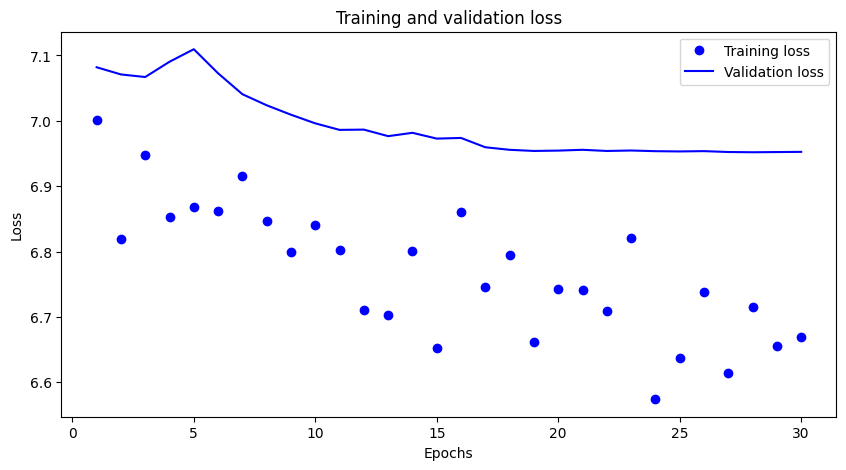

In [ ]:
# 모델 학습 함수 수정
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plot_training_history(train_losses, val_losses)

# 모델 학습 및 검증
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

*데이터 증강, 하이퍼파라미터 튜닝, 모델 아키텍처 개선*

*데이터 증강*

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop((max_len, max_dim), scale=(0.8, 1.0))
])


*하이퍼파라미터* *튜닝*

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # SGD 대신 Adam 사용


*모델아키텍처* *개선*

In [ ]:
class CNNclassification(nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (max_len // 16) * (max_dim // 16), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool3(self.bn3(torch.relu(self.conv3(x))))
        x = self.pool4(self.bn4(torch.relu(self.conv4(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


*조기종료 및 학습률 감소*

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=50):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

            _, predicted = output.max(1)
            total_train += y_batch.size(0)
            correct_train += predicted.eq(y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)

                _, predicted = output.max(1)
                total_val += y_batch.size(0)
                correct_val += predicted.eq(y_batch).sum().item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# 모델 학습 및 검증
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)


KeyboardInterrupt: 